<a href="https://colab.research.google.com/github/oAndreAmaral/MasterThesis/blob/Preliminary-Work/LSTM_Preliminary_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Normalization Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Deep Learning Pytorch Library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
#torch.cuda.is_available()
#torch.cuda.get_device_name(0)

In [ ]:

from google.colab import files
 
 
uploaded = files.upload()

Saving simu_data_cleaned.csv to simu_data_cleaned.csv


# Data Pre-Processing

In [ ]:
df = pd.read_csv('simu_data_cleaned.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
#df.drop('/out+ Y', axis = 1, inplace = True)
df.head()

,/out- X,/out- Y,/out+ Y,/net2 Y,/net02 Y,/net07 Y
0,0.000000,0.070629,0.070629,0.250000,0.25,0.0
1,0.000361,0.070796,0.070541,0.250227,0.25,0.0
2,0.000527,0.070895,0.070489,0.250331,0.25,0.0
3,0.000859,0.071116,0.070372,0.250540,0.25,0.0
4,0.001158,0.071330,0.070259,0.250727,0.25,0.0


####  Prepare the data

First we define the training set, which will contain the data we want to predict:

In [ ]:
training_set_param = df.drop(['/out- Y', '/out+ Y'], axis = 1).values
training_set_labels = df[['/out- Y', '/out+ Y']].values

In [ ]:
training_set_param.shape

(4465, 4)

In [ ]:
training_set_labels.shape

(4465, 2)

Then we need to construct a function for the sliding window:

In [ ]:
def sliding_windows(data1, data2, seq_length):
    x = []
    y = []

    for i in range(len(data1)-seq_length-1):
        _x = data1[i:(i+seq_length)] # input: the seq_length of data
        _y = data2[i+seq_length] #Output: the next value after the input 
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# this function take as arguments the data and a certain sequence length and append to an x an y variable the respective 
# previous data and the value that needs to be predicted

After that is necessary to normalize the input data using MinMaxScale:

In [ ]:
scaler = MinMaxScaler()
training_set_param = scaler.fit_transform(training_set_param)
#training_set_labels = scaler.transform(training_set_labels)

Now we define the sequence length, in other words the number of data we want in the input set for example, if the length is 10 we will have 10 numbers in the input.

In [ ]:
seq_length = 2
x, y = sliding_windows(training_set_param, training_set_labels, seq_length)

In [ ]:
x.shape

(4462, 2, 4)

In [ ]:
y[0]

array([0.07089465, 0.07048886])

Split the data in train and test sets:

In [ ]:
# Define the train and test size
train_size = int(len(y) * 0.66)
test_size = len(y) - train_size

# Define all dataset
all_dataX = Variable(torch.Tensor(np.array(x)).cuda())
all_dataY = Variable(torch.Tensor(np.array(y)).cuda())

# Define the training set
trainX = Variable(torch.Tensor(np.array(x[0:train_size])).cuda())
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).cuda())

# Define the test set
testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])).cuda())
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])).cuda())

# Define the Model

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        # Define Variables to be used in the "forward" path
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # Define the layers that will be used
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        # initialize the "Long Short Term Memory Gate" and "Short Term Memory Gate"
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        
        # Propagate the input through LSTM module
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
              
        # Passing finaly through a fully conected layer with linear activation function
        out = self.fc1(h_out.view(-1, self.hidden_size))
        
        return out

#### Define the Model, Loss and Optimizer

In [ ]:
# Define the Model with the input parameters
lstm = LSTM(num_classes=2, input_size=4, hidden_size=200, num_layers=1).cuda()
# Define the criterion: mean-squared error loss since we are working with regression problem
criterion = torch.nn.MSELoss()
# Define the Optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

#### Train The Model

In [ ]:
number_of_epochs = 500

for epoch in range(number_of_epochs):
    # Initialize the gradient to avoid value agregations
    optimizer.zero_grad()
    
    # Predict the model using the training set
    y_pred = lstm(trainX)
        
    # Obtain the loss
    loss = criterion(y_pred, trainY)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Print the results
    if epoch % 10 == 0:
      print("Epoch: %d, loss: %.5E" % (epoch, loss.item()))

Epoch: 0, loss: 1.18620E-02
Epoch: 10, loss: 8.59271E-04
Epoch: 20, loss: 6.53375E-05
Epoch: 30, loss: 1.32598E-04
Epoch: 40, loss: 5.51512E-05
Epoch: 50, loss: 4.73169E-05
Epoch: 60, loss: 4.57241E-05
Epoch: 70, loss: 4.04331E-05
Epoch: 80, loss: 3.77841E-05
Epoch: 90, loss: 3.53811E-05
Epoch: 100, loss: 3.24524E-05
Epoch: 110, loss: 2.89036E-05
Epoch: 120, loss: 2.48316E-05
Epoch: 130, loss: 2.05955E-05
Epoch: 140, loss: 1.68122E-05
Epoch: 150, loss: 1.40030E-05
Epoch: 160, loss: 1.22118E-05
Epoch: 170, loss: 1.10944E-05
Epoch: 180, loss: 1.02951E-05
Epoch: 190, loss: 9.58909E-06
Epoch: 200, loss: 8.85617E-06
Epoch: 210, loss: 8.04907E-06
Epoch: 220, loss: 7.16781E-06
Epoch: 230, loss: 6.24741E-06
Epoch: 240, loss: 5.35146E-06
Epoch: 250, loss: 4.55651E-06
Epoch: 260, loss: 3.92643E-06
Epoch: 270, loss: 3.48328E-06
Epoch: 280, loss: 3.19934E-06
Epoch: 290, loss: 3.02657E-06
Epoch: 300, loss: 6.22551E-06
Epoch: 310, loss: 4.21212E-06
Epoch: 320, loss: 2.80319E-06
Epoch: 330, loss: 2.8

# Predict on the Training Set

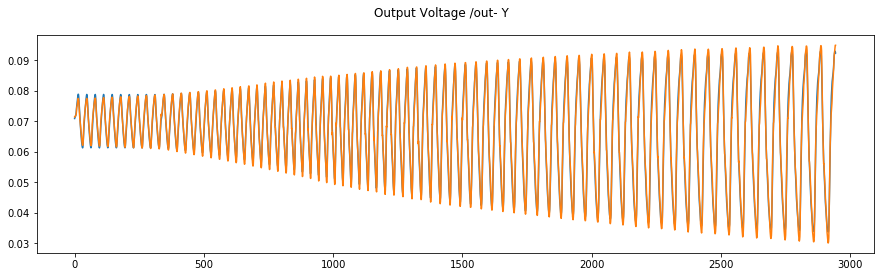

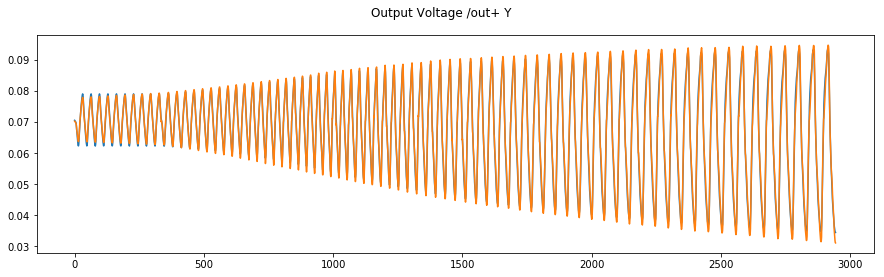

In [ ]:
# Start evaluation method and make the prediction tensor
lstm.eval()
train_predict = lstm(trainX)

# Convert the train prediction and the train label to numpy vectors
train_predict = train_predict.cpu().data.numpy()
train_label_plot = trainY.cpu().data.numpy()

# Plot the graphics with the results
plt.figure(figsize=(15,4))
plt.plot(train_label_plot[:,0])
plt.plot(train_predict[:,0])
plt.suptitle('Output Voltage /out- Y')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(train_label_plot[:,1])
plt.plot(train_predict[:,1])
plt.suptitle('Output Voltage /out+ Y')
plt.show()

In [ ]:
print("Mean Squared Error for Train /out- Y: %.5E" % (mean_squared_error(train_label_plot[:,0], train_predict[:,0])))
print("Mean Squared Error for Train /out+ Y: %.5E" % (mean_squared_error(train_label_plot[:,1], train_predict[:,1])))

Mean Squared Error for Train /out- Y: 2.55400E-06
Mean Squared Error for Train /out+ Y: 2.19439E-06


# Predict on the Test Set

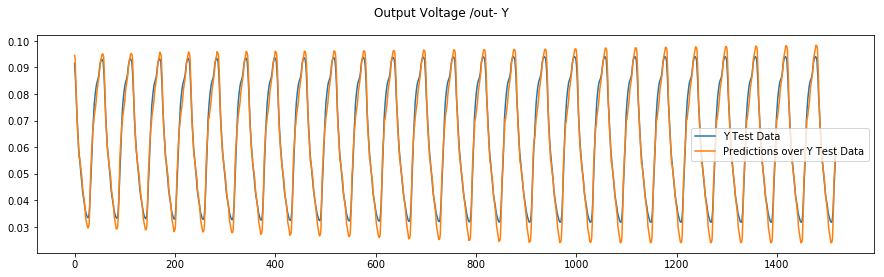

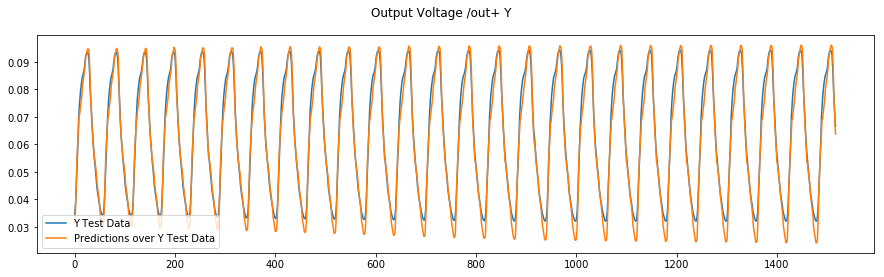

In [ ]:
# Start evaluation method and make the prediction tensor
lstm.eval()
test_predict = lstm(testX)

# Convert the train prediction and the train label to numpy vectors
test_predict = test_predict.cpu().data.numpy()
test_label_plot = testY.cpu().data.numpy()


# Plot the graphics with the results
plt.figure(figsize=(15,4))
plt.plot(test_label_plot[:,0], label="Y Test Data")
plt.plot(test_predict[:,0], label="Predictions over Y Test Data")
plt.suptitle('Output Voltage /out- Y')
plt.legend()
plt.show()

plt.figure(figsize=(15,4))
plt.plot(test_label_plot[:,1], label="Y Test Data")
plt.plot(test_predict[:,1], label="Predictions over Y Test Data")
plt.suptitle('Output Voltage /out+ Y')
plt.legend()
plt.show()

In [ ]:
print("Mean Squared Error for Test /out- Y: %.5E" % (mean_squared_error(test_label_plot[:,0], test_predict[:,0])))
print("Mean Squared Error for Test /out+ Y: %.5E" % (mean_squared_error(test_label_plot[:,1], test_predict[:,1])))

Mean Squared Error for Test /out- Y: 1.27106E-05
Mean Squared Error for Test /out+ Y: 1.27065E-05
